In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# for predicting shipping on time and late delivery 
df = pd.read_csv('df_ontime_vs_late.csv')
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [3]:
df = df.drop(columns=[
    'Late_delivery_risk'
], axis=1)

In [4]:
df_obj = df.select_dtypes(include='object')
df_obj.drop(columns=['Delivery Status'], axis=1, inplace=True)

In [5]:
#one hot encoder
def onehotencoder(col):
    
    ohe = OneHotEncoder()
    ohe_array = ohe.fit_transform((pd.DataFrame(col))).toarray()

    feature_labels = np.array(ohe.categories_).ravel()


    df_obj = pd.DataFrame(ohe_array, columns=feature_labels)
    
    return df_obj

In [6]:
df_ohe = pd.DataFrame()
for c in df_obj.columns:
    one_hot = onehotencoder(df_obj[c])
    df_ohe = pd.concat([df_ohe, one_hot], axis=1) 

In [7]:
df_cont_var = df.select_dtypes(exclude='object')

In [8]:
df_ohe = pd.concat([df_cont_var, df_ohe], axis=1)

In [9]:
df_ohe = pd.concat([df_ohe, df['Delivery Status'] ], axis=1)

In [10]:
df=df_ohe

In [11]:
# y variable values set equal to label encode the dataframes column being used for y
le = LabelEncoder()
y = le.fit_transform(df['Delivery Status'])

In [12]:
# x variable
X = df.drop(columns=['Delivery Status'], axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, test_size=.2)

### Random Search

In [14]:
# scaling data
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [15]:
scaler_x_train = scaler.transform(X_train)

In [16]:
scaler.fit(X_test)
scaler_x_test = scaler.transform(X_test)

#### Random Forest Models

##### Training Model

In [17]:
rf_param_grid={
    'criterion':['gini', 'entropy'],
    'max_depth':[10,70],
    'min_samples_split':[50,100],
    'min_samples_leaf':[1,100],
}

In [18]:
rf = RandomForestClassifier()
rf_rand_search = RandomizedSearchCV(rf, rf_param_grid)

rf_rand_search.fit(scaler_x_train, y_train)
rfc_pred_train = rf_rand_search.predict(scaler_x_train)

In [19]:
print(classification_report(y_train, rfc_pred_train, target_names=le.classes_))

                  precision    recall  f1-score   support

   Late delivery       0.89      0.63      0.74     79045
Shipping on time       0.64      0.89      0.75     59164

        accuracy                           0.74    138209
       macro avg       0.77      0.76      0.74    138209
    weighted avg       0.78      0.74      0.74    138209



In [20]:
print('Mean Absolute Error:', mean_absolute_error(y_train, rfc_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, rfc_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, rfc_pred_train)))

Mean Absolute Error: 0.25589505748540253
Mean Squared Error: 0.25589505748540253
Root Mean Squared Error: 0.5058607095687533


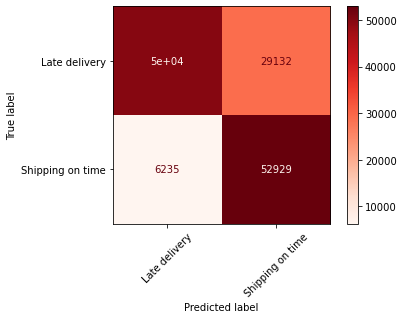

In [21]:
plot_confusion_matrix(rf_rand_search, scaler_x_train, y_train,
                      cmap=plt.cm.Reds)

plt.xticks(ticks=range(0,len(le.classes_)),labels=le.classes_, rotation=45)
plt.yticks(ticks=range(0,len(le.classes_)),labels=le.classes_)

plt.show()

#### Testing Model

In [22]:
rfc_pred_test = rf_rand_search.predict(scaler_x_test)

In [23]:
print(classification_report(y_test, rfc_pred_test, target_names=le.classes_))

                  precision    recall  f1-score   support

   Late delivery       0.87      0.58      0.70     19931
Shipping on time       0.61      0.89      0.72     14622

        accuracy                           0.71     34553
       macro avg       0.74      0.73      0.71     34553
    weighted avg       0.76      0.71      0.71     34553



In [24]:
print('Mean Absolute Error:', mean_absolute_error(y_test, rfc_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, rfc_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, rfc_pred_test)))

Mean Absolute Error: 0.2902208201892745
Mean Squared Error: 0.2902208201892745
Root Mean Squared Error: 0.5387214680976381


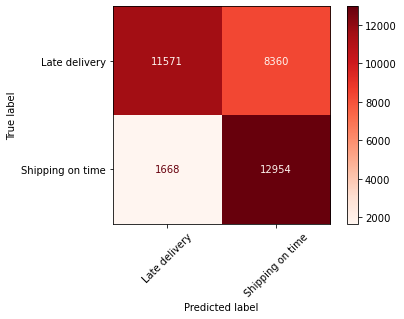

In [25]:
plot_confusion_matrix(rf_rand_search, scaler_x_test, y_test,
                      cmap=plt.cm.Reds)

plt.xticks(ticks=range(0,len(le.classes_)),labels=le.classes_, rotation=45)
plt.yticks(ticks=range(0,len(le.classes_)),labels=le.classes_)

plt.show()

#### XGBoost Models

In [26]:
xgb_param_grid={
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'gamma': [0, 1, 2, 3],
    'max_depth': [20,60],
    'min_child_weight': [1, 2],
    'subsample': [0.2, 0.5, 0.7, 0.9],
}

##### Training Model

In [27]:
xgb = XGBClassifier(eval_metric='mlogloss')
xgb_rand_search = RandomizedSearchCV(xgb, xgb_param_grid)

xgb_rand_search.fit(scaler_x_train, y_train)
xgb_pred_train = xgb_rand_search.predict(scaler_x_train)

In [28]:
print(classification_report(y_train, xgb_pred_train, target_names=le.classes_))

                  precision    recall  f1-score   support

   Late delivery       1.00      1.00      1.00     79045
Shipping on time       1.00      1.00      1.00     59164

        accuracy                           1.00    138209
       macro avg       1.00      1.00      1.00    138209
    weighted avg       1.00      1.00      1.00    138209



In [29]:
print('Mean Absolute Error:', mean_absolute_error(y_train, xgb_pred_train))
print('Mean Squared Error:', mean_squared_error(y_train, xgb_pred_train))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, xgb_pred_train)))

Mean Absolute Error: 0.002358746536043239
Mean Squared Error: 0.002358746536043239
Root Mean Squared Error: 0.04856692841886585


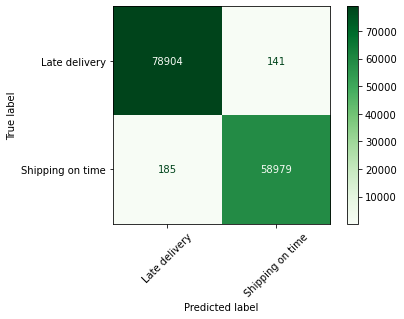

In [30]:
plot_confusion_matrix(xgb_rand_search, scaler_x_train, y_train,
                      cmap=plt.cm.Greens)

plt.xticks(ticks=range(0,len(le.classes_)),labels=le.classes_, rotation=45)
plt.yticks(ticks=range(0,len(le.classes_)),labels=le.classes_)

plt.show()

##### Testing Model

In [31]:
xgb_pred_test = xgb_rand_search.predict(scaler_x_test)

In [32]:
print(classification_report(y_test, xgb_pred_test, target_names=le.classes_))

                  precision    recall  f1-score   support

   Late delivery       0.84      0.75      0.79     19931
Shipping on time       0.70      0.81      0.75     14622

        accuracy                           0.78     34553
       macro avg       0.77      0.78      0.77     34553
    weighted avg       0.78      0.78      0.78     34553



In [33]:
print('Mean Absolute Error:', mean_absolute_error(y_test, xgb_pred_test))
print('Mean Squared Error:', mean_squared_error(y_test, xgb_pred_test))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, xgb_pred_test)))

Mean Absolute Error: 0.224640407489943
Mean Squared Error: 0.224640407489943
Root Mean Squared Error: 0.4739624536711141


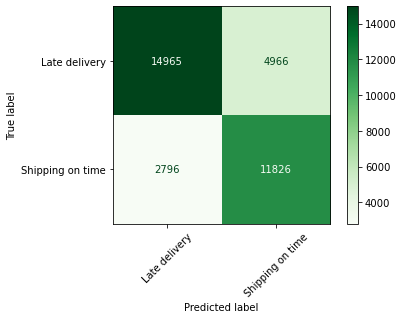

In [34]:
plot_confusion_matrix(xgb_rand_search, scaler_x_test, y_test,
                      cmap=plt.cm.Greens)

plt.xticks(ticks=range(0,len(le.classes_)),labels=le.classes_, rotation=45)
plt.yticks(ticks=range(0,len(le.classes_)),labels=le.classes_)

plt.show()

In [35]:
#.64 rfc before corr change
#.65 rfc after corr change
#.69 xgboost before corr change
#.68 after corr change


In [36]:
#.71 rfc after delivery status category change to considering shipping on time 
# and late delivery

# .78 xgb